<a href="https://colab.research.google.com/github/Lupama2/IntroCUDA/blob/main/GoogleColab/ICNPG_epidemia.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#@title Solo si les da un error relacionado a "UTF..." corran esto... 
import locale
def getpreferredencoding(do_setlocale = True):
    return "UTF-8"
locale.getpreferredencoding = getpreferredencoding

# Modelo SIR de epidemias

Vamos a simular un modelo para la evolución de la población susceptible $S$, infectada $I$ y recuperada $R$. Vamos a considerar $N$ poblaciones independientes, descriptas por $S_i, I_i, R_i$ con $i=0,...,N-1$, cada una con la misma tasa de recuperación $\beta$ pero disntinta tasa de transmissión $\beta_i$.

$$
\begin{align}
\frac{dS_i}{dt} &= -\beta_i S_i I_i \\ 
\frac{dI_i}{dt} &= \beta_i S_i I_i - \gamma I_i \\
\frac{dR_i}{dt} &= \gamma I_i
\end{align}
$$ 

Son tres ecuaciones acopladas. Sin embargo, podemos resolver solo para dos variables, ya que hay una ley de conservación $S_i+I_i+R_i=\text{constante}$.
Vamos sin embargo a resolver el sistema con las tres variables, pensando en posibles extensiones del modelo.

Esta aplicación es un ejemplo de "paralelización vergonzosa" donde se puede ganar una acelaración importante respecto de la implementación secuencial.

La resolución numérica más simple es por diferencias finitas, usando el esquema de Euler, con un paso de tiempo suficientemente chico $dt$. Si llamamos $S_i^n \equiv S_i(n dt)$, y lo mismo para $I_i^n$, y $R_i^n$, tenemos

$$
\begin{align}
S_i^{n+1} &= S_i^n - dt\; \beta_i S_i^{n} I_i^n \\ 
I_i^{n+1} &= I_i^n + dt\; \beta_i S_i^n I_i^n - \gamma I_i^n \\
R_i^{n+1} &= R_i^n + dt\; \gamma I_i^n
\end{align}
$$ 

La idea básica de los algoritmos paralalos es asignar a cada hilo el trabajo de avanzar un paso de Euler las tres variables de una población $i$.


## NUMPY (secuencial)

In [ ]:
#@title modelo SIR en numpy 

import numpy as np

N = 10 # nro de poblaciones
g = 0.1  # tasa de recuperacion
dt = 0.1  # paso de tiempo

# Declarar y Alocar memoria para los arrays de device S, I, R y beta usando CuPy
# ....
S = np.zeros(N, dtype=np.float32)
I = np.zeros(N, dtype=np.float32)
R = np.zeros(N, dtype=np.float32)
beta = np.zeros(N, dtype=np.float32)

# aqui vamos a guardar las derivadas con respecto al tiempo (arrays auxiliares) 
dSdt = np.zeros(N, dtype=np.float32)
dIdt = np.zeros(N, dtype=np.float32)
dRdt = np.zeros(N, dtype=np.float32)

# Inicializar S[i]=0.999, I[i]=0.001, R[i]=0, y beta[i]=0.02+i*0.02 usando CuPy
# ....
S.fill(np.float32(0.999))
I.fill(np.float32(0.001))
R.fill(np.float32(0.0))
beta.fill(np.float32(0.1))

beta = np.arange(N, dtype=np.float32)
beta = np.float32(0.02)+np.float32(0.02)*beta

print("S=",S, len(beta))
print("I=",I, len(beta))
print("R=",R, len(beta))
print("beta=",beta, len(beta))

ntot = 5000

f = open("data8.csv", "w")
    
# loop de tiempo
for p in range(ntot):
    # imprimir I[] en columnas
    
    np.savetxt(f, I.reshape(1, -1), delimiter='\t', fmt='%f')

    # derivadas de S[],I[],R[]
    dSdt = -beta*S*I
    dIdt = -dSdt-g*I
    dRdt = g*I

    # paso de Euler
    S = S+dSdt*dt
    I = I+dIdt*dt
    R = R+dRdt*dt


S= [0.999 0.999 0.999 0.999 0.999 0.999 0.999 0.999 0.999 0.999] 10
I= [0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001] 10
R= [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] 10
beta= [0.02       0.04       0.06       0.08       0.09999999 0.11999999
 0.14       0.16       0.17999999 0.19999999] 10


In [ ]:
#@title visualicemos los tiempos (ask chatgpt: "Plot 10 column csv file using Python")
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

def dibujame(datafile):
  # Read in the data from the CSV file
  data1 = pd.read_csv(datafile, delimiter='\t', header=None)

  # Create an arange to use as the x-axis
  x1 = np.arange(len(data1))

  # Plot each column of data against the x-axis
  for col in data1.columns:
      plt.plot(x1, data1[col], label=col)

  # Add a legend and labels for the axes
  plt.legend()
  plt.xlabel('tiempo')
  plt.ylabel('Infectados')
  plt.title(datafile)

  # Show the plot
  plt.tight_layout()
  plt.show()  

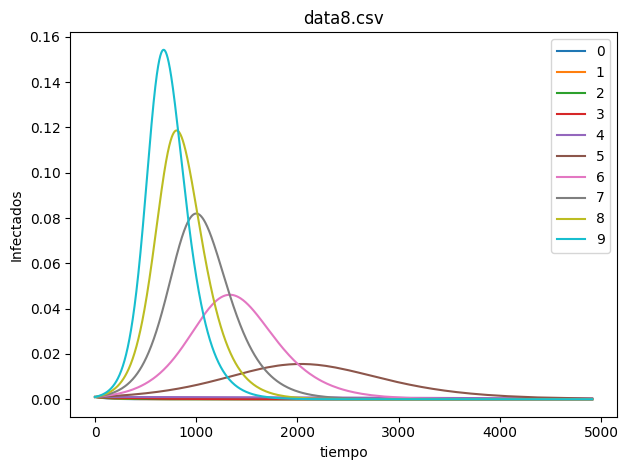

In [ ]:
dibujame("data8.csv")

___

## [version Thrust](https://thrust.github.io/)

In [ ]:
#@title Modelo SIR en Thrust + CUDA
%%writefile sir.cu
/*
	Vamos a resolver el modelo SIR de epidemias
	
	dS/dt = -beta*S*I
	dI/dt = beta*S*I - gamma*I
	dR/dt = gamma*I

 	para N valores de beta
*/


// Poner los #include que hagan falta!
#include<thrust/device_vector.h>
#include<thrust/fill.h>
#include<thrust/sequence.h>

#define gamma	0.1  // tasa de recuperacion
#define Dt	0.1  // paso de tiempo

// escribir un Kernel "modeloSIR" que actualice los arrays S, I, R, cada elemento con diferente beta
// ....
// ....
__global__ void modeloSIR(float *S, float *I, float *R, float *beta, int N)
{
	int i = threadIdx.x + blockIdx.x*blockDim.x;

	if(i<N){
		//dS/dt = -beta*S*I --> newS = S - Dt*beta*S*I
		float newS = S[i] - Dt*beta[i]*S[i]*I[i];

    //dI/dt = beta*S*I - gamma*I
		float newI = I[i] + Dt*(beta[i]*S[i]*I[i]-gamma*I[i]);

    //dR/dt = gamma*I
		float newR = R[i] + Dt*(gamma*I[i]);

		S[i]=newS;
		I[i]=newI;
		R[i]=newR;
	}
}

int main(void)
{
    int N=10;

    // Declarar y Alocar memoria para los arrays de device S, I, R y beta usando thrust 
    // ....
    thrust::device_vector<float> S(N);
    thrust::device_vector<float> I(N);
    thrust::device_vector<float> R(N);
    thrust::device_vector<float> beta(N);

    // Inicializar S[i]=0.999, I[i]=0.001, R[i]=0, y beta[i]=0.02+i*0.02 usando Thrust
    // ....
    thrust::fill(S.begin(),S.end(),0.999);
    thrust::fill(I.begin(),I.end(),0.001);
    thrust::fill(R.begin(),R.end(),0.0);

    thrust::sequence(beta.begin(),beta.end(),0.02,0.02);

    int ntot=5000;
	
    // loop de tiempo
    for(int n=0;n<ntot;n++){	

      // imprimir I[] en columnas
      for(int i=0;i<N;i++){
        std::cout << I[i] << "\t";
      }
      std::cout << "\n";

      // extraer los punteros crudos Sraw, Iraw, Rraw, Betaraw de los vectores de thrust
      float *Sraw = thrust::raw_pointer_cast(&S[0]);   
      float *Iraw = thrust::raw_pointer_cast(&I[0]);   
      float *Rraw = thrust::raw_pointer_cast(&R[0]);   
      float *betaraw = thrust::raw_pointer_cast(&beta[0]);   

      // Llamar al kernel de actualizacion de S[],I[],R[]
      modeloSIR<<< (N+32-1)/32,32>>>(Sraw,Iraw,Rraw,betaraw,N);
    }
}


Writing sir.cu


In [ ]:
!nvcc sir.cu -o sir; ./sir > data1.csv

In [ ]:
!tail data1.csv

3.87098e-21	8.78522e-17	1.91674e-12	3.82262e-08	0.000342179	0.000266012	1.36985e-06	9.17414e-09	1.17357e-10	2.81345e-12	
3.84e-21	8.73245e-17	1.90904e-12	3.81482e-08	0.000342056	0.000265534	1.3655e-06	9.13477e-09	1.16746e-10	2.79669e-12	
3.80927e-21	8.67999e-17	1.90138e-12	3.80704e-08	0.000341934	0.000265057	1.36116e-06	9.09557e-09	1.16139e-10	2.78004e-12	
3.77879e-21	8.62786e-17	1.89375e-12	3.79928e-08	0.000341811	0.000264581	1.35683e-06	9.05655e-09	1.15535e-10	2.76349e-12	
3.74855e-21	8.57603e-17	1.88614e-12	3.79153e-08	0.000341688	0.000264105	1.35252e-06	9.01768e-09	1.14934e-10	2.74704e-12	
3.71855e-21	8.52452e-17	1.87857e-12	3.7838e-08	0.000341566	0.00026363	1.34822e-06	8.97899e-09	1.14336e-10	2.73068e-12	
3.6888e-21	8.47332e-17	1.87103e-12	3.77608e-08	0.000341443	0.000263157	1.34393e-06	8.94046e-09	1.13741e-10	2.71442e-12	
3.65928e-21	8.42242e-17	1.86351e-12	3.76838e-08	0.000341321	0.000262684	1.33966e-06	8.9021e-09	1.1315e-10	2.69826e-12	
3.62999e-21	8.37183e-17	1.85603e-12	3.760

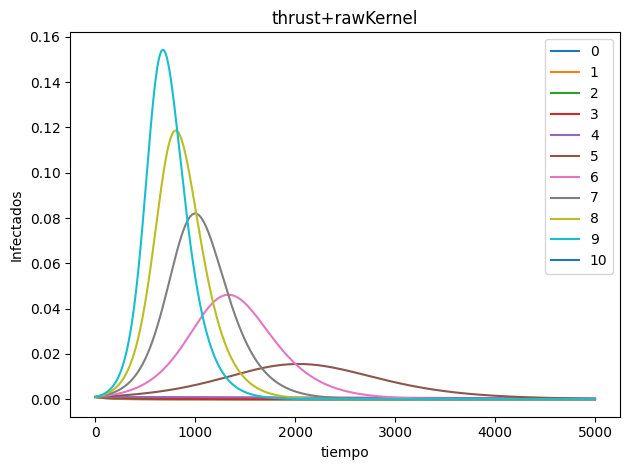

In [ ]:
dibujame("data1.csv")

___

## version [cupy](https://cupy.dev/) con [RawKernel](https://docs.cupy.dev/en/stable/reference/generated/cupy.RawKernel.html)

Copiamos el kernel en C anterior en un string y construimos una función que podemos llamar desde python, usando cupy arrays para manejar la memoria de device y host, asi como la inicialización.

In [ ]:
#@title modelo SIR en cupy usando RawKernel

import cupy as cp
import numpy as np
import cupyx

# define the kernel as a string
SIRkernel = cp.RawKernel(r'''
  extern "C" 
  {
    __global__ 
    void modeloSIR(float *S, float *I, float *R, float *beta, float g, float dt, int N)
    {
      int i = threadIdx.x + blockIdx.x*blockDim.x;

      //printf("i=%d, gamma=%f N=%d",i, gamma, N);

      float newS=0, newI=0, newR=0;
      float oldS=0, oldI=0, oldR=0;

      oldS=S[i];
      oldI=I[i];
      oldR=R[i];

      float b=beta[i];

      if(i<N){

        newS = oldS - dt * b * oldS * oldI;

        newI = oldI + dt * (b*oldS*oldI - g*oldI);

        newR = oldR + dt * (g*oldI);

        S[i]=newS;
        I[i]=newI;
        R[i]=newR;
      }
  }
}''', 'modeloSIR')


N = 10 # nro de poblaciones
g = 0.1  # tasa de recuperacion
dt = 0.1  # paso de tiempo

# Declarar y Alocar memoria para los arrays de device S, I, R y beta usando CuPy
# ....
S = cp.zeros(N, dtype=cp.float32)
I = cp.zeros(N, dtype=cp.float32)
R = cp.zeros(N, dtype=cp.float32)
beta = cp.zeros(N, dtype=cp.float32)

# Inicializar S[i]=0.999, I[i]=0.001, R[i]=0, y beta[i]=0.02+i*0.02 usando CuPy
# ....
S.fill(cp.float32(0.999))
I.fill(cp.float32(0.001))
R.fill(cp.float32(0.0))
beta.fill(cp.float32(0.1))

beta = cp.arange(N, dtype=cp.float32)
beta = cp.float32(0.02)+cp.float32(0.02)*beta

print("S=",S, len(beta))
print("I=",I, len(beta))
print("R=",R, len(beta))
print("beta=",beta, len(beta))

ntot = 5000

f = open("data2.csv", "w")
    
h_I = np.zeros(N, dtype=np.float32)
#h_I=I.get()
#np.savetxt(f, h_I.reshape(1, -1), delimiter='\t', fmt='%f')

# loop de tiempo
for p in range(ntot):
  # imprimir I[] en columnas
    # ...
    h_I=I.get()
    
    #print(h_I[0],h_I[1])
    np.savetxt(f, h_I.reshape(1, -1), delimiter='\t', fmt='%f')

    block_size = 256
    grid_size = (N + block_size - 1)//block_size

    # Llamar al kernel de actualizacion de S[],I[],R[]
    SIRkernel((grid_size,), (block_size,), (S, I, R, beta, cp.float32(g), cp.float32(dt), N))

    #cp.cuda.Device().synchronize()
    

S= [0.999 0.999 0.999 0.999 0.999 0.999 0.999 0.999 0.999 0.999] 10
I= [0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001] 10
R= [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] 10
beta= [0.02       0.04       0.06       0.08       0.09999999 0.11999999
 0.14       0.16       0.17999999 0.19999999] 10


In [ ]:
!tail data2.csv; wc -l data2.csv

0.000000	0.000000	0.000000	0.000000	0.000353	0.000310	0.000002	0.000000	0.000000	0.000000
0.000000	0.000000	0.000000	0.000000	0.000353	0.000310	0.000002	0.000000	0.000000	0.000000
0.000000	0.000000	0.000000	0.000000	0.000353	0.000309	0.000002	0.000000	0.000000	0.000000
0.000000	0.000000	0.000000	0.000000	0.000352	0.000309	0.000002	0.000000	0.000000	0.000000
0.000000	0.000000	0.000000	0.000000	0.000352	0.000308	0.000002	0.000000	0.000000	0.000000
0.000000	0.000000	0.000000	0.000000	0.000352	0.000308	0.000002	0.000000	0.000000	0.000000
0.000000	0.000000	0.000000	0.000000	0.000352	0.000307	0.000002	0.000000	0.000000	0.000000
0.000000	0.000000	0.000000	0.000000	0.000352	0.000307	0.000002	0.000000	0.000000	0.000000
0.000000	0.000000	0.000000	0.000000	0.000352	0.000306	0.000002	0.000000	0.000000	0.000000
0.000000	0.000000	0.000000	0.000000	0.000352	0.000306	0.000002	0.000000	0.000000	0.000000
4914 data2.csv


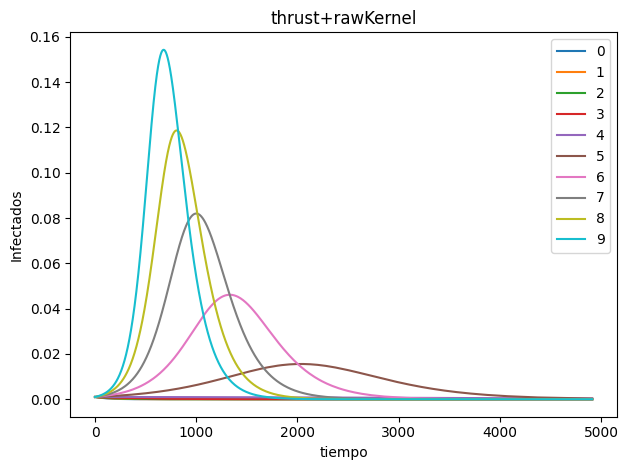

In [ ]:
dibujame("data2.csv")

___

## version [cupy](https://docs.cupy.dev/en/stable/index.html) sin kernels

Se usan [multiply](https://docs.cupy.dev/en/stable/reference/generated/cupy.multiply.html#cupy.multiply) y [add](https://docs.cupy.dev/en/stable/reference/generated/cupy.add.html) y otras funciones también copiadas y paralelizadas de [numpy](https://numpy.org/), con la misma interface. 

Esta versión es mucho mas simple porque no usa kernels, pero es menos eficientes porque usa mas memoria y lanza más kernels (por debajo, delegado a cupy).


In [ ]:
#@title modelo SIR en cupy puro sin kernels

import cupy as cp
import numpy as np
import cupyx

N = 10 # nro de poblaciones
g = 0.1  # tasa de recuperacion
dt = 0.1  # paso de tiempo

# Declarar y Alocar memoria para los arrays de device S, I, R y beta usando CuPy
# ....
S = cp.zeros(N, dtype=cp.float32)
I = cp.zeros(N, dtype=cp.float32)
R = cp.zeros(N, dtype=cp.float32)
beta = cp.zeros(N, dtype=cp.float32)

# aqui vamos a guardar las derivadas con respecto al tiempo (arrays auxiliares) 
dSdt = cp.zeros(N, dtype=cp.float32)
dIdt = cp.zeros(N, dtype=cp.float32)
dRdt = cp.zeros(N, dtype=cp.float32)

# Inicializar S[i]=0.999, I[i]=0.001, R[i]=0, y beta[i]=0.02+i*0.02 usando CuPy
# ....
S.fill(cp.float32(0.999))
I.fill(cp.float32(0.001))
R.fill(cp.float32(0.0))
beta.fill(cp.float32(0.1))

beta = cp.arange(N, dtype=cp.float32)
beta = cp.float32(0.02)+cp.float32(0.02)*beta

print("S=",S, len(beta))
print("I=",I, len(beta))
print("R=",R, len(beta))
print("beta=",beta, len(beta))

ntot = 5000

f = open("data3.csv", "w")
    
h_I = np.zeros(N, dtype=np.float32)

# loop de tiempo
for p in range(ntot):
  # imprimir I[] en columnas
    # ...
    h_I=I.get()
    
    #print(h_I[0],h_I[1])
    np.savetxt(f, h_I.reshape(1, -1), delimiter='\t', fmt='%f')

    # derivadas de S[],I[],R[]
    dSdt = -cp.multiply(beta,cp.multiply(S, I))
    dIdt = cp.add(-dSdt,-g*I)
    dRdt = g*I

    # paso de Euler
    S = cp.add(S,dSdt*dt)
    I = cp.add(I,dIdt*dt)
    R = cp.add(R,dRdt*dt)

    # tambien se puede usar asi!
    # derivadas de S[],I[],R[]
    #dSdt = -beta*S*I
    #dIdt = -dSdt-g*I
    #dRdt = g*I
    # paso de Euler
    #S = S+dSdt*dt
    #I = I+dIdt*dt
    #R = R+dRdt*dt

    #cp.cuda.Device().synchronize()
    

S= [0.999 0.999 0.999 0.999 0.999 0.999 0.999 0.999 0.999 0.999] 10
I= [0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001] 10
R= [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] 10
beta= [0.02       0.04       0.06       0.08       0.09999999 0.11999999
 0.14       0.16       0.17999999 0.19999999] 10


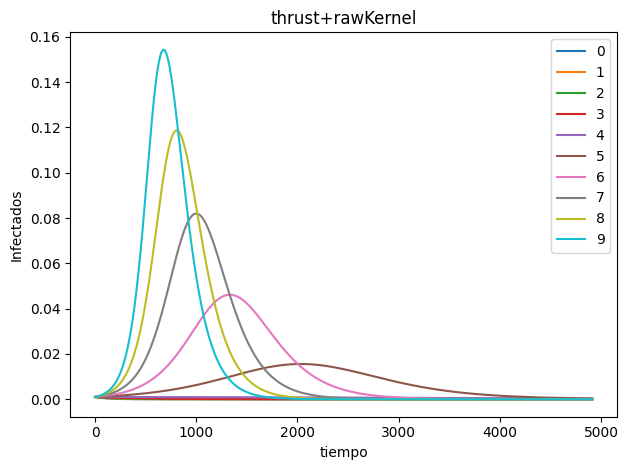

In [ ]:
dibujame("data3.csv")

___

## version [numba](https://numba.pydata.org/) usando kernels escritos en python

Se escribe un kernel, pero en python, no en C, y se compila en tiempo de corrida usando sus "jit" compilers. 

In [ ]:
#@title modelo SIR en numba

import numpy as np
from numba import cuda
import cupy as cp
import cupyx


@cuda.jit
def SIRkernel(S,I,R,beta,g,dt,N):
      i = cuda.threadIdx.x + cuda.blockIdx.x*cuda.blockDim.x;
      if i<N:
        oldS = S[i]
        oldI = I[i]
        oldR = R[i]
        b=beta[i]

        newS = oldS - dt * b * oldS * oldI;
        newI = oldI + dt * (b*oldS*oldI - g*oldI);
        newR = oldR + dt * (g*oldI);

        S[i]=newS;
        I[i]=newI;
        R[i]=newR;

N = 10 # nro de poblaciones
g = 0.1  # tasa de recuperacion
dt = 0.1  # paso de tiempo

# Declarar y Alocar memoria para los arrays de device S, I, R y beta usando CuPy
# ....
S = cp.zeros(N, dtype=cp.float32)
I = cp.zeros(N, dtype=cp.float32)
R = cp.zeros(N, dtype=cp.float32)
beta = cp.zeros(N, dtype=cp.float32)

# Inicializar S[i]=0.999, I[i]=0.001, R[i]=0, y beta[i]=0.02+i*0.02 usando CuPy
# ....
S.fill(cp.float32(0.999))
I.fill(cp.float32(0.001))
R.fill(cp.float32(0.0))
beta.fill(cp.float32(0.1))

beta = cp.arange(N, dtype=cp.float32)
beta = cp.float32(0.02)+cp.float32(0.02)*beta

print("S=",S, len(beta))
print("I=",I, len(beta))
print("R=",R, len(beta))
print("beta=",beta, len(beta))

ntot = 5000

f = open("data4.csv", "w")
    
h_I = np.zeros(N, dtype=np.float32)
#h_I=I.get()
#np.savetxt(f, h_I.reshape(1, -1), delimiter='\t', fmt='%f')

# loop de tiempo
for p in range(ntot):
  # imprimir I[] en columnas
    # ...
    h_I=I.get()
    
    #print(h_I[0],h_I[1])
    np.savetxt(f, h_I.reshape(1, -1), delimiter='\t', fmt='%f')

    block_size = 256
    grid_size = (N + block_size - 1)//block_size

    # Llamar al kernel de actualizacion de S[],I[],R[]
    SIRkernel[grid_size, block_size](S, I, R, beta, cp.float32(g), cp.float32(dt), N)

    #cp.cuda.Device().synchronize()
    

S= [0.999 0.999 0.999 0.999 0.999 0.999 0.999 0.999 0.999 0.999] 10
I= [0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001] 10
R= [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] 10
beta= [0.02       0.04       0.06       0.08       0.09999999 0.11999999
 0.14       0.16       0.17999999 0.19999999] 10


/usr/local/lib/python3.10/dist-packages/numba/cuda/dispatcher.py:488: NumbaPerformanceWarning: Grid size 1 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))


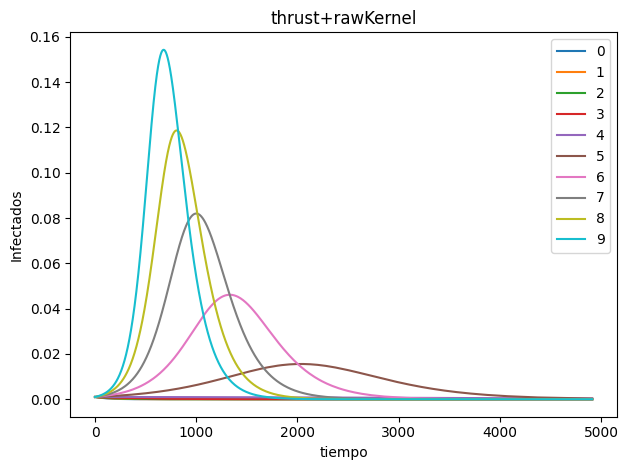

In [ ]:
dibujame("data4.csv")

___

## Version thrust pura, sin kernels

Tiene la ventaja de ser portable, cpu o gpu.


In [ ]:
#@title Modelo SIR en Thrust pura 
%%writefile sir2.cu
/*
	Vamos a resolver el modelo SIR de epidemias
	
	dS/dt = -beta*S*I
	dI/dt = beta*S*I - gamma*I
	dR/dt = gamma*I

 	para N valores de beta
*/


// Poner los #include que hagan falta!
#include<thrust/device_vector.h>
#include<thrust/fill.h>
#include<thrust/sequence.h>

#define gamma	0.1  // tasa de recuperacion
#define Dt	0.1  // paso de tiempo


int main(void)
{
    int N=10;

    // Declarar y Alocar memoria para los arrays de device S, I, R y beta usando thrust 
    // ....
    thrust::device_vector<float> S(N);
    thrust::device_vector<float> I(N);
    thrust::device_vector<float> R(N);
    thrust::device_vector<float> beta(N);

    // Inicializar S[i]=0.999, I[i]=0.001, R[i]=0, y beta[i]=0.02+i*0.02 usando Thrust
    // ....
    thrust::fill(S.begin(),S.end(),0.999);
    thrust::fill(I.begin(),I.end(),0.001);
    thrust::fill(R.begin(),R.end(),0.0);

    thrust::sequence(beta.begin(),beta.end(),0.02,0.02);

    int ntot=5000;
	
    // loop de tiempo
    for(int n=0;n<ntot;n++){	

      // imprimir I[] en columnas
      for(int i=0;i<N;i++){
        std::cout << I[i] << "\t";
      }
      std::cout << "\n";

      thrust::for_each(
        thrust::make_zip_iterator(
          thrust::make_tuple(S.begin(), I.begin(), R.begin(),beta.begin())
        ),
        thrust::make_zip_iterator(
          thrust::make_tuple(S.end(), I.end(), R.end(),beta.end())
        ),
        [=] __device__ (auto tup)
        {
          float oldS=thrust::get<0>(tup);
          float oldI=thrust::get<1>(tup);
          float oldR=thrust::get<2>(tup);
          float b = thrust::get<3>(tup);

          thrust::get<0>(tup) = oldS - Dt*(b*oldS*oldI);
          thrust::get<1>(tup) = oldI + Dt*(b*oldS*oldI-gamma*oldI);
          thrust::get<2>(tup) = oldR - Dt*(gamma*oldI);
        }

      );
    }
}


Writing sir2.cu


In [ ]:
!nvcc --extended-lambda sir2.cu -o sir2; ./sir2 > data5.csv

In [ ]:
!tail data5.csv

3.87098e-21	8.78522e-17	1.91674e-12	3.82262e-08	0.000342179	0.000266012	1.36985e-06	9.17414e-09	1.17357e-10	2.81344e-12	
3.84e-21	8.73245e-17	1.90904e-12	3.81482e-08	0.000342056	0.000265534	1.3655e-06	9.13477e-09	1.16746e-10	2.79669e-12	
3.80927e-21	8.67999e-17	1.90138e-12	3.80704e-08	0.000341934	0.000265057	1.36115e-06	9.09557e-09	1.16139e-10	2.78004e-12	
3.77879e-21	8.62786e-17	1.89375e-12	3.79928e-08	0.000341811	0.000264581	1.35683e-06	9.05655e-09	1.15535e-10	2.76348e-12	
3.74855e-21	8.57603e-17	1.88614e-12	3.79153e-08	0.000341688	0.000264105	1.35251e-06	9.01768e-09	1.14934e-10	2.74703e-12	
3.71855e-21	8.52452e-17	1.87857e-12	3.7838e-08	0.000341566	0.00026363	1.34821e-06	8.97899e-09	1.14336e-10	2.73067e-12	
3.6888e-21	8.47332e-17	1.87103e-12	3.77608e-08	0.000341443	0.000263157	1.34393e-06	8.94046e-09	1.13741e-10	2.71441e-12	
3.65928e-21	8.42242e-17	1.86351e-12	3.76838e-08	0.000341321	0.000262684	1.33966e-06	8.9021e-09	1.1315e-10	2.69825e-12	
3.62999e-21	8.37183e-17	1.85603e-12	3.760

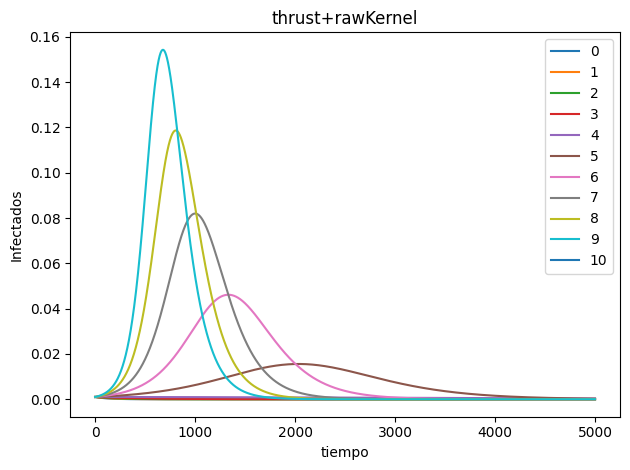

In [ ]:
dibujame("data5.csv")

___

## Experimentando mas con cupy


En el siguiente ejemplo fusionamos todas las operaciones element-wise usando [cupy.fuse](https://docs.cupy.dev/en/stable/reference/generated/cupy.fuse.html) para ciertas operaciones element-wise. Si fusiona todo en un solo kernel, deberia ser una optimizacion con respecto a la version simple, al reducir el numero de lecturas (probarlo).

In [ ]:
#@title modelo SIR en cupy puro sin kernels, con cp.fuse (optimizacion).


import cupy as cp
import numpy as np

@cp.fuse(kernel_name='my_fused_kernel')
def my_fused_kernel(S, I, R, dSdt, dIdt, dRdt, beta, g, dt):
    # derivadas de S[],I[],R[]
    dSdt[:] = -beta*S*I
    dIdt[:] = -dSdt-g*I
    dRdt[:] = g*I

    # paso de Euler
    S[:] = S+dSdt*dt
    I[:] = I+dIdt*dt
    R[:] = R+dRdt*dt

N = 10 # nro de poblaciones
g = 0.1  # tasa de recuperacion
dt = 0.1  # paso de tiempo

# Declarar y Alocar memoria para los arrays de device S, I, R y beta usando CuPy
# ....
S = cp.zeros(N, dtype=cp.float32)
I = cp.zeros(N, dtype=cp.float32)
R = cp.zeros(N, dtype=cp.float32)
beta = cp.zeros(N, dtype=cp.float32)

# aqui vamos a guardar las derivadas con respecto al tiempo (arrays auxiliares) 
dSdt = cp.zeros(N, dtype=cp.float32)
dIdt = cp.zeros(N, dtype=cp.float32)
dRdt = cp.zeros(N, dtype=cp.float32)

# Inicializar S[i]=0.999, I[i]=0.001, R[i]=0, y beta[i]=0.02+i*0.02 usando CuPy
# ....
S.fill(cp.float32(0.999))
I.fill(cp.float32(0.001))
R.fill(cp.float32(0.0))
beta.fill(cp.float32(0.1))

beta = cp.arange(N, dtype=cp.float32)
beta = cp.float32(0.02)+cp.float32(0.02)*beta

print("S=",S, len(beta))
print("I=",I, len(beta))
print("R=",R, len(beta))
print("beta=",beta, len(beta))

ntot = 5000

f = open("data7.csv", "w")
    
h_I = np.zeros(N, dtype=np.float32)

# loop de tiempo
for p in range(ntot):
  # imprimir I[] en columnas
    # ...
    h_I=I.get()
    
    #print(h_I[0],h_I[1])
    np.savetxt(f, h_I.reshape(1, -1), delimiter='\t', fmt='%f')

    my_fused_kernel(S, I, R, dSdt, dIdt, dRdt, beta, g, dt)
    
    #cp.cuda.Device().synchronize()
    

S= [0.999 0.999 0.999 0.999 0.999 0.999 0.999 0.999 0.999 0.999] 10
I= [0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001] 10
R= [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] 10
beta= [0.02       0.04       0.06       0.08       0.09999999 0.11999999
 0.14       0.16       0.17999999 0.19999999] 10


In [ ]:
!tail data7.csv

0.000000	0.000000	0.000000	0.000000	0.000342	0.000266	0.000001	0.000000	0.000000	0.000000
0.000000	0.000000	0.000000	0.000000	0.000342	0.000266	0.000001	0.000000	0.000000	0.000000
0.000000	0.000000	0.000000	0.000000	0.000342	0.000265	0.000001	0.000000	0.000000	0.000000
0.000000	0.000000	0.000000	0.000000	0.000342	0.000265	0.000001	0.000000	0.000000	0.000000
0.000000	0.000000	0.000000	0.000000	0.000342	0.000264	0.000001	0.000000	0.000000	0.000000
0.000000	0.000000	0.000000	0.000000	0.000342	0.000264	0.000001	0.000000	0.000000	0.000000
0.000000	0.000000	0.000000	0.000000	0.000341	0.000263	0.000001	0.000000	0.000000	0.000000
0.000000	0.000000	0.000000	0.000000	0.000341	0.000263	0.000001	0.000000	0.000000	0.000000
0.000000	0.000000	0.000000	0.000000	0.000341	0.000262	0.000001	0.000000	0.000000	0.000000
0.000000	0.000000	0.000000	0.000000	0.000341	0.000262	0.000001	0.000000	0.000000	0.000000


In [ ]:
dibujame("data7.csv")